In [1]:
using Pkg
Pkg.activate("../")
#Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [2]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using DataFrames
using PythonCall
using Statistics
using Interpolations
using SparseArrays
sacc = pyimport("sacc");

# Judith's Chain

In [3]:
function make_Cmod(m, model)
    T = ForwardDiff.jacobian(model, zeros(m))
    return T * T'
end

make_Cmod (generic function with 1 method)

## Data

In [4]:
method = "sompz" # "bpz", "lognormal" or "sompz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/gcgc.yml"
nz_path = string("../data/CosmoDC2/nzs_", method, "/dz_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "dz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "dz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "dz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "dz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "dz_lens_4.npz"))

meta, files = make_data(sacc_file, yaml_file;
    nz_lens_0=nz_lens_0,
    nz_lens_1=nz_lens_1,
    nz_lens_2=nz_lens_2,
    nz_lens_3=nz_lens_3,
    nz_lens_4=nz_lens_4)

meta.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"];

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


## dz

In [6]:
nz_path = string("../data/CosmoDC2/nzs_", method, "/dz_priors/")
nz_lens_0 = npzread(string(nz_path, "dz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "dz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "dz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "dz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "dz_lens_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

chol_lens_0 = nz_lens_0["chol"]
chol_lens_1 = nz_lens_1["chol"]
chol_lens_2 = nz_lens_2["chol"]
chol_lens_3 = nz_lens_3["chol"]
chol_lens_4 = nz_lens_4["chol"];

In [7]:
function model_dz(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    dz_lens_0 = chol_lens_0 * alphas[1]
    dz_lens_1 = chol_lens_1 * alphas[2]
    dz_lens_2 = chol_lens_2 * alphas[3]
    dz_lens_3 = chol_lens_3 * alphas[4]
    dz_lens_4 = chol_lens_4 * alphas[5]

    lens_0_zs   = @.(zs_k0 + dz_lens_0)
    lens_1_zs   = @.(zs_k1 + dz_lens_1)
    lens_2_zs   = @.(zs_k2 + dz_lens_2)
    lens_3_zs   = @.(zs_k3 + dz_lens_3)
    lens_4_zs   = @.(zs_k4 + dz_lens_4)

    nuisances = Dict(
    "lens_0_b"    => lens_0_b,
    "lens_1_b"    => lens_1_b,
    "lens_2_b"    => lens_2_b,
    "lens_3_b"    => lens_3_b,
    "lens_4_b"    => lens_4_b,
    "lens_0_zs"   => lens_0_zs,
    "lens_1_zs"   => lens_1_zs,
    "lens_2_zs"   => lens_2_zs,
    "lens_3_zs"   => lens_3_zs,
    "lens_4_zs"   => lens_4_zs)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [8]:
Cmod_dz = make_Cmod(10, model_dz);

## wzdz

In [9]:
nz_path = string("../data/CosmoDC2/nzs_", method, "/wzdz_priors/")

nz_lens_0 = npzread(string(nz_path, "wzdz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "wzdz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "wzdz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "wzdz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "wzdz_lens_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

chol_lens_0 = nz_lens_0["chol"]
chol_lens_1 = nz_lens_1["chol"]
chol_lens_2 = nz_lens_2["chol"]
chol_lens_3 = nz_lens_3["chol"]
chol_lens_4 = nz_lens_4["chol"];

In [10]:
function model_wzdz(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    snw_lens_0 = chol_lens_0 * alphas[1:2]
    dz_lens_0 = snw_lens_0[1]
    wz_lens_0 = 1 + snw_lens_0[2]

    snw_lens_1 = chol_lens_1 * alphas[3:4]
    dz_lens_1 = snw_lens_1[1]
    wz_lens_1 = 1 + snw_lens_1[2]

    snw_lens_2 = chol_lens_2 * alphas[5:6]
    dz_lens_2 = snw_lens_2[1]
    wz_lens_2 = 1 + snw_lens_2[2]

    snw_lens_3 = chol_lens_3 * alphas[7:8]
    dz_lens_3 = snw_lens_3[1]
    wz_lens_3 = 1 + snw_lens_3[2]

    snw_lens_4 = chol_lens_4 * alphas[9:10]
    dz_lens_4 = snw_lens_4[1]
    wz_lens_4 = 1 + snw_lens_4[2]
    
    lens_0_zs   = @.((zs_k0 - mu_k0 + dz_lens_0) / wz_lens_0 + mu_k0)
    lens_1_zs   = @.((zs_k1 - mu_k1 + dz_lens_1) / wz_lens_1 + mu_k1)
    lens_2_zs   = @.((zs_k2 - mu_k2 + dz_lens_2) / wz_lens_2 + mu_k2)
    lens_3_zs   = @.((zs_k3 - mu_k3 + dz_lens_3) / wz_lens_3 + mu_k3)
    lens_4_zs   = @.((zs_k4 - mu_k4 + dz_lens_4) / wz_lens_4 + mu_k4)


    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_zs"   => lens_0_zs,
        "lens_1_zs"   => lens_1_zs,
        "lens_2_zs"   => lens_2_zs,
        "lens_3_zs"   => lens_3_zs,
        "lens_4_zs"   => lens_4_zs)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [11]:
Cmod_wzdz = make_Cmod(20, model_wzdz);

## PCA

In [12]:
nz_path = string("../data/CosmoDC2/nzs_", method, "/PCA_priors/")
nz_lens_0 = npzread(string(nz_path, "PCA_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "PCA_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "PCA_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "PCA_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "PCA_lens_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

W_lens_0 = nz_lens_0["W"]
W_lens_1 = nz_lens_1["W"]
W_lens_2 = nz_lens_2["W"]
W_lens_3 = nz_lens_3["W"]
W_lens_4 = nz_lens_4["W"];

In [13]:
function model_pca(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    nz_lens_0 = nz_k0 + W_lens_0 * alphas[1:5]
    nz_lens_1 = nz_k1 + W_lens_1 * alphas[6:10]
    nz_lens_2 = nz_k2 + W_lens_2 * alphas[11:15]
    nz_lens_3 = nz_k3 + W_lens_3 * alphas[16:20]
    nz_lens_4 = nz_k4 + W_lens_4 * alphas[21:25]

    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_nz"   => nz_lens_0,
        "lens_1_nz"   => nz_lens_1,
        "lens_2_nz"   => nz_lens_2,
        "lens_3_nz"   => nz_lens_3,
        "lens_4_nz"   => nz_lens_4)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [14]:
Cmod_pca = make_Cmod(50, model_pca);

## GP

In [15]:
nz_path = string("../data/CosmoDC2/nzs_", method, "/gp_priors/")
nz_lens_0 = npzread(string(nz_path, "gp_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "gp_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "gp_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "gp_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "gp_lens_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

W_lens_0 = nz_lens_0["W"]
W_lens_1 = nz_lens_1["W"]
W_lens_2 = nz_lens_2["W"]
W_lens_3 = nz_lens_3["W"]
W_lens_4 = nz_lens_4["W"];


In [16]:
function nz_itp(q, nq, z)
    dq = mean(q[2:end] - q[1:end-1])
    q_range = q[1]:dq:q[end]
    nz_int = cubic_spline_interpolation(q_range, nq;
        extrapolation_bc=Line())
    return nz_int(z)
end

function model_gp(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    nz_lens_0 = nz_k0 + W_lens_0 * alphas[1:5]
    nz_lens_1 = nz_k1 + W_lens_1 * alphas[6:10]
    nz_lens_2 = nz_k2 + W_lens_2 * alphas[11:15]
    nz_lens_3 = nz_k3 + W_lens_3 * alphas[16:20]
    nz_lens_4 = nz_k4 + W_lens_4 * alphas[21:25]

    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_nz"   => nz_lens_0,
        "lens_1_nz"   => nz_lens_1,
        "lens_2_nz"   => nz_lens_2,
        "lens_3_nz"   => nz_lens_3,
        "lens_4_nz"   => nz_lens_4)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [17]:
Cmod_gp = make_Cmod(50, model_gp);

# Comp

In [18]:
cov = meta.cov
if method == "sompz"
    cov *= 0.03
end
;

In [19]:
println(mean(diag(Cmod_dz) ./ diag(cov)))
println(mean(diag(Cmod_wzdz) ./ diag(cov)))
println(mean(diag(Cmod_pca) ./ diag(cov)))
println(mean(diag(Cmod_gp) ./ diag(cov)))

0.0022633741154889832
0.2436089063505499
0.3558546987488302
0.31429776086697814


In [20]:
"""
# Lognormal Y1
6.200300896439334
7.827457882076686
9.41116689060237
6.7362586812727345

# Pathlogical Nz
0.3306897241224036
0.3629603435884084
0.3680708756027848
0.36197849438889784
"""

"# Lognormal Y1\n6.200300896439334\n7.827457882076686\n9.41116689060237\n6.7362586812727345\n\n# Pathlogical Nz\n0.3306897241224036\n0.3629603435884084\n0.3680708756027848\n0.36197849438889784\n"

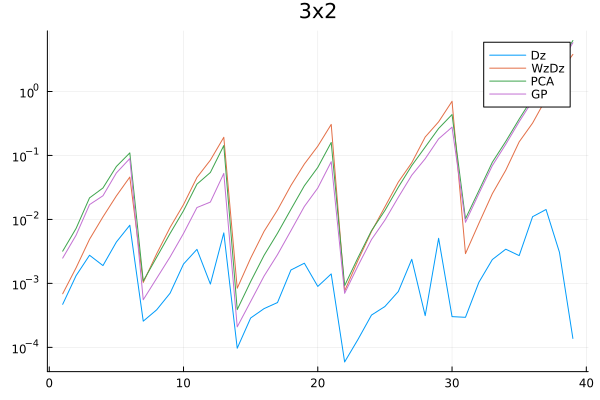

In [21]:
plot(diag(Cmod_dz) ./ diag(cov), label="Dz", yscale=:log10, title="3x2")
plot!(diag(Cmod_wzdz) ./ diag(cov), label="WzDz")
plot!(diag(Cmod_pca) ./ diag(cov), label="PCA")
plot!(diag(Cmod_gp) ./ diag(cov), label="GP")

## Save

In [22]:
using NPZ
npzwrite(string("../covs/COSMODC2/", method, "_gcgc_tpts_covs.npz"),
        Dict(
        "cov"     => cov,
        "TT_dz"   => Symmetric(cov + Cmod_dz),
        "TT_wzdz" => Symmetric(cov + Cmod_wzdz),
        "TT_pca"  => Symmetric(cov + Cmod_pca),
        "TT_gp"   => Symmetric(cov + Cmod_gp)))